# 9장. 선형분류모델
## 9.1 이항 분류 모델

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from ch09 import *
from helper import generate_batches
plt.rcParams['figure.figsize'] = (4, 4)

In [2]:
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])
labels = np.array([[0],[0],[0],[1],[1],[1]], dtype=np.int32)
print(xy)
print(labels)

[[0.2  0.4 ]
 [0.4  0.2 ]
 [0.65 0.3 ]
 [0.8  0.5 ]
 [0.5  0.8 ]
 [0.25 0.8 ]]
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]]


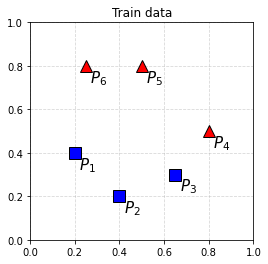

In [3]:
example_plot_wo_contour(xy, labels, 'Train data')

### 9.1.1 연속 확률 모델

#### Model A

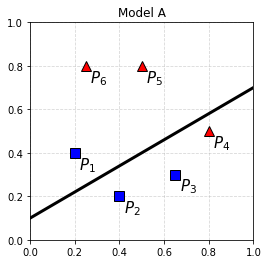

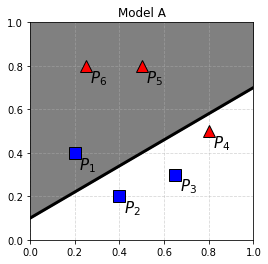

In [4]:
example_plot_only_line(xy, labels, 0.6, .1, 'Model A')
example_plot(xy, labels, 0.6, .1, 'Model A')

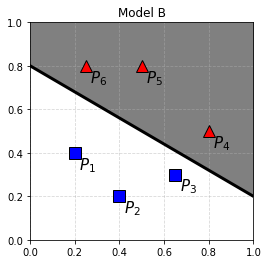

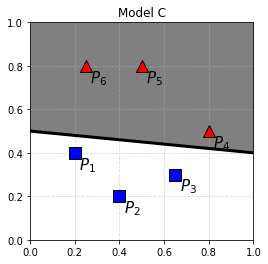

In [5]:
example_plot(xy, labels, -.6, .8, 'Model B')
example_plot(xy, labels, -.1, .5, 'Model C')

#### 시그모이드

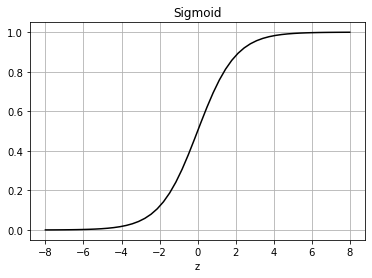

In [6]:
tmp = np.linspace(-8,8)
sigmoid = lambda z:  1.0 / (1+np.exp(-z))

plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(tmp, sigmoid(tmp), 'k')
plt.grid()
plt.xlabel('z')
plt.title('Sigmoid')
plt.show()

#### Model B

In [7]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 결정경계선의 일반형 식의 계수(W)
        self.b = tf.Variable([-8.]) # 결정경계선의 일반형 식의 상수항(b)

    def call(self, x): # x: 데이터 좌표 (x,y)
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

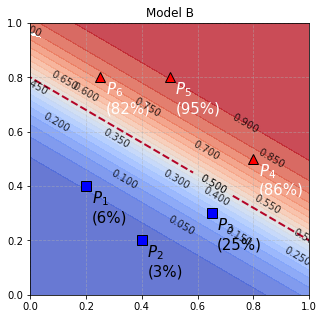

In [8]:
feature = lambda x, y: [x,y]
plot_model(model, feature, xy, labels, 'Model B')

#### Model C

In [9]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[10.]])
        self.b = tf.Variable([-5.])

    def call(self, x):
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

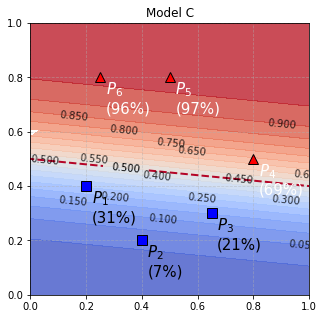

In [10]:
feature = lambda x, y: [x,y]
plot_model(model, feature, xy, labels, 'Model C')

### 9.1.2 최대우도법과 크로스 엔트로피

#### Model B - 최대우도법

In [11]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 결정경계선의 일반형 식의 계수(W)
        self.b = tf.Variable([-8.]) # 결정경계선의 일반형 식의 상수항(b)

    def call(self, x): # x: 데이터 좌표 (x,y)
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

In [12]:
model = MyModel()

pred = model(xy).numpy()
print(pred)
pred[0:3] = 1.0 - pred[0:3]
print(pred)
prob = np.prod(pred)
print(prob)

[[0.05732417]
 [0.02659699]
 [0.24973983]
 [0.85814893]
 [0.95257413]
 [0.81757444]]
[[0.9426758 ]
 [0.973403  ]
 [0.7502602 ]
 [0.85814893]
 [0.95257413]
 [0.81757444]]
0.4601037


#### Model C - 최대우도법

In [13]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[10.]])
        self.b = tf.Variable([-5.])

    def call(self, x):
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

In [14]:
model = MyModel()

pred = model(xy).numpy()
print(pred)
pred[0:3] = 1.0 - pred[0:3]
print(pred)
prob = np.prod(pred)
print(prob)

[[0.3100255 ]
 [0.06913835]
 [0.20587042]
 [0.6899745 ]
 [0.9706878 ]
 [0.9626731 ]]
[[0.6899745 ]
 [0.93086165]
 [0.7941296 ]
 [0.6899745 ]
 [0.9706878 ]
 [0.9626731 ]]
0.32885242


#### Model B - 크로스 엔트로피

In [15]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 결정경계선의 일반형 식의 계수(W)
        self.b = tf.Variable([-8.]) # 결정경계선의 일반형 식의 상수항(b)

    def call(self, x): # x: 데이터 좌표 (x,y)
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

model = MyModel()

In [16]:
loss = lambda p, phat: tf.reduce_sum(- p * tf.math.log(phat) - (1 - p) * tf.math.log(1 - phat))
loss_val = loss(labels, model(xy)).numpy()
print(loss_val)
pred = model(xy).numpy()
pred[0:3] = 1.0 - pred[0:3]
prob = np.prod(pred)
print(-np.log(prob))

0.77630347
0.7763034


### 9.1.3 미니 배치 방법을 통한 모델 학습

In [17]:
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])
labels = np.array([[0],[0],[0],[1],[1],[1]], dtype=np.int32)

class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[1.]]) 
        self.b = tf.Variable([-1.]) 

    def call(self, x): 
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

loss = lambda p, phat: tf.reduce_mean(- p * tf.math.log(phat) - (1 - p) * tf.math.log(1 - phat))

model = MyModel()

In [18]:
features = xy

MaxEpochs = 50
lr = 1.0
optimizer = tf.keras.optimizers.Adam(lr)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
batch_size = 10
for epoch in range(MaxEpochs):
    if epoch % 5 == 0:
        curr_loss = loss(labels, model(features))
        print(model.w.numpy().T, model.b.numpy(), curr_loss.numpy())

    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1. 1.]] [-1.] 0.57861006
[[0.2567941 2.7253065]] [-2.2425592] 0.52684075
[[1.2269577 5.8030834]] [-2.511906] 0.35873517
[[0.7806473 7.295685 ]] [-4.3874187] 0.259053
[[1.9248078 9.424852 ]] [-5.0507555] 0.18241803
[[ 2.5612829 10.770933 ]] [-6.191628] 0.13992596
[[ 3.0603893 11.742464 ]] [-7.3698945] 0.11698825
[[ 4.066818 12.919807]] [-7.9656763] 0.09489024
[[ 4.6228566 13.727168 ]] [-8.742903] 0.08052508
[[ 4.9657845 14.368889 ]] [-9.512419] 0.071203925


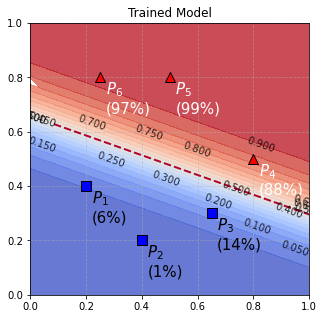

In [19]:
plot_model(model, lambda x, y: [x,y], xy, labels, 'Trained Model')

### 9.1.4 특성값을 이용한 비선형 분류 모델

In [20]:
from sklearn.datasets import make_circles
xy, labels = make_circles(n_samples=400, noise=0.1)

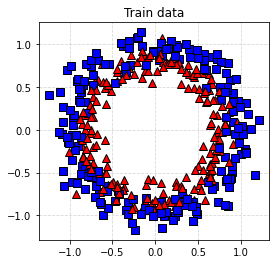

In [21]:
c_shape = ['bs', 'r^']
for k, (point, label) in enumerate(zip(xy, labels.reshape(-1,1)),1):
    x,y = point
    plt.plot(x, y, c_shape[label[0]], mec='k', markersize=8)

plt.grid(linestyle='--', alpha=0.5)
plt.title('Train data')
plt.gca().set_aspect('equal', adjustable='box')

In [22]:
# 특성값 정의
features = np.array([[xval**2, yval**2] for xval, yval in xy])

In [23]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[1.]]) 
        self.b = tf.Variable([-0.25]) 

    def call(self, x): 
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [24]:
model = MyModel()

loss = lambda p, phat: tf.reduce_mean(- p * tf.math.log(phat) - (1 - p) * tf.math.log(1 - phat))

In [25]:
def plot_model(model, feature_labmda, title):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.5,1.5, 200), np.linspace(-1.5,1.5, 200))
    inputs_xy = np.array([feature_labmda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])
    prediction = model(inputs_xy).numpy()
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    colors = {0:'red', 1:'blue'}
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    ax.contourf(xx, yy, Z, 5, cmap='coolwarm', alpha=.9)
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    grouped = df.groupby('label')
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k]], mec='k', alpha=0.6)
    ax.set_xlim([-1.3, 1.3])
    ax.set_ylim([-1.3, 1.3])
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

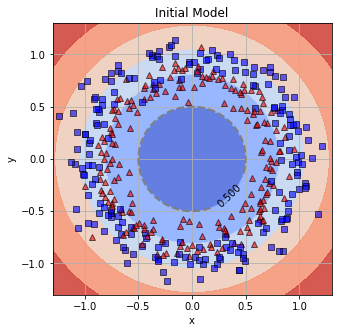

In [26]:
model = MyModel()
plot_model(model, lambda x,y: [x**2, y**2], 'Initial Model')

In [27]:
# 수치최적화 알고리즘
MaxEpochs = 100
lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
batch_size = 10
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

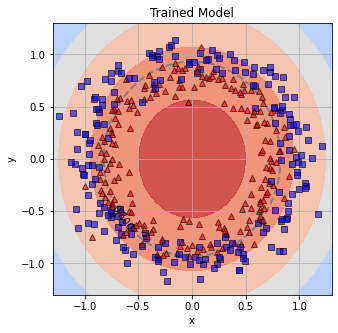

In [28]:
plot_model(model, lambda x,y: [x**2, y**2], 'Trained Model')

## 9.2 다중 분류 모델
### 9.2.2 원-핫(One-hot) 인코딩

In [29]:
np.random.seed(402)
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])

# 특성값 정의
features = np.array([[xval, yval] for xval, yval in xy])
print('좌표 데이터:\n', features, '\n')

# 원-핫 인코딩
labels = np.array([[0, 1],[0, 1],[0, 1],[1, 0],[1, 0],[1, 0]])
print('레이블:\n', labels)

좌표 데이터:
 [[0.2  0.4 ]
 [0.4  0.2 ]
 [0.65 0.3 ]
 [0.8  0.5 ]
 [0.5  0.8 ]
 [0.25 0.8 ]] 

레이블:
 [[0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]]


### 9.2.4 미니 배치 방법을 통한 모델 학습

In [30]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.W = tf.Variable(tf.ones([2,2]), dtype=tf.float32) 
        self.b = tf.Variable(tf.ones([2]), dtype=tf.float32) 

    def call(self, x):
        return tf.nn.softmax(tf.matmul(x, self.W) + self.b)

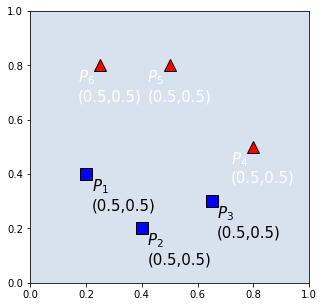

In [31]:
model = MyModel()
plot_scatter_softmax(model.W.numpy(), model.b.numpy(), xy, labels)

In [32]:
loss = lambda p, phat: tf.reduce_mean(tf.reduce_sum(- p * tf.math.log(phat),1))

MaxEpochs = 25
lr = 0.5
optimizer = tf.keras.optimizers.Adam(lr)

In [33]:
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

from helper import generate_batches

batch_size = 3
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 5 == 0:
        print(epoch, model.W.numpy(), model.b.numpy(), curr_loss.numpy())

0 [[1.945563   0.05443704]
 [0.8577205  1.1422795 ]] [0.72328013 1.2767199 ] 1.2344422
5 [[ 1.6084906   0.39150962]
 [ 2.971559   -0.9715587 ]] [-0.19685197  2.1968522 ] 0.3975285
10 [[ 1.616149    0.38385153]
 [ 4.739495   -2.7394943 ]] [-1.219996   3.2199957] 0.1698374
15 [[ 2.324847   -0.32484618]
 [ 6.0415444  -4.041544  ]] [-2.0235872  4.0235868] 0.123032205
20 [[ 2.9550228 -0.9550221]
 [ 6.91511   -4.9151096]] [-2.749179  4.749178] 0.09799708


In [34]:
print(loss(labels,model(features)).numpy())

print('W:\n', model.W.numpy())
print('b:\n', model.b.numpy())
print('prediction:\n', model(features).numpy())

0.087647684
W:
 [[ 3.2890172 -1.2890162]
 [ 7.4371214 -5.4371204]]
b:
 [-3.2588093  5.258808 ]
prediction:
 [[0.0792695  0.9207305 ]
 [0.01611822 0.98388183]
 [0.15714537 0.84285456]
 [0.8294777  0.1705223 ]
 [0.9832224  0.01677756]
 [0.9491306  0.05086941]]


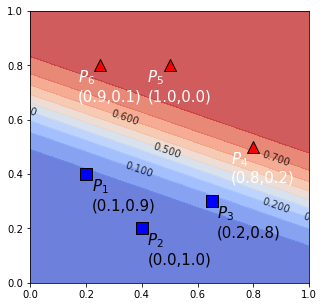

In [35]:
plot_scatter_softmax(model.W.numpy(), model.b.numpy(), xy, labels)

### 9.2.5 MNIST

In [36]:
mnist = tf.keras.datasets.mnist

In [37]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

label_train = tf.one_hot(y_train,10)

In [38]:
from collections import Counter
freq = Counter([label for label in y_train])
for k in range(0,10):
    print("label {0} : {1}개".format(k, freq[k]))

label 0 : 5923개
label 1 : 6742개
label 2 : 5958개
label 3 : 6131개
label 4 : 5842개
label 5 : 5421개
label 6 : 5918개
label 7 : 6265개
label 8 : 5851개
label 9 : 5949개


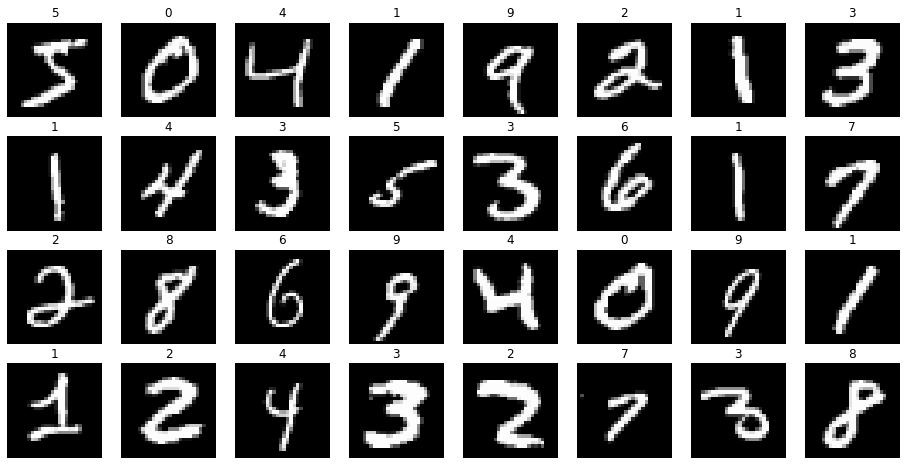

In [39]:
plt.figure(figsize=(16,8))
for k in range(32):
    img = x_train[k].reshape(28,28)
    label = y_train[k]
    plt.subplot(4,8,1+k)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(label)
plt.show()

In [40]:
feature_train = x_train.reshape(-1,784)
feature_test = x_test.reshape(-1,784)

label_train = tf.one_hot(y_train,10).numpy()
label_test = tf.one_hot(y_test,10).numpy()

In [41]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.W = tf.Variable(tf.zeros([784,10]), dtype=tf.float32) 
        self.b = tf.Variable(tf.zeros([10]), dtype=tf.float32) 

    def call(self, x):
        return tf.nn.softmax(tf.matmul(x, self.W) + self.b)

In [42]:
model = MyModel()
loss = lambda p, phat: tf.reduce_mean(tf.reduce_sum(- p * tf.math.log(phat),1))

In [43]:
MaxEpochs = 1
lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

In [44]:
def accuracy(x,y):
    yhat = model(x)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(yhat,1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [45]:
np.random.seed(320)
shuffled_id = np.arange(0, len(feature_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = feature_train[shuffled_id]
shuffled_y_train = label_train[shuffled_id]

In [46]:
batch_size = 256
for epoch in range(MaxEpochs):
    step = 0
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        step += 1
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            if step % 20 == 0:
                curr_W, curr_b, curr_loss = model.W.numpy(), model.b.numpy(), loss(label_train,model(feature_train))
                curr_acc = accuracy(feature_test, label_test)
                print(epoch, step, curr_loss.numpy(), curr_acc.numpy())

0 20 0.47939718 0.8707
0 40 0.38976413 0.898
0 60 0.34956884 0.9083
0 80 0.33822846 0.9114
0 100 0.33309454 0.9094
0 120 0.31662512 0.9121
0 140 0.30841598 0.9124
0 160 0.3041841 0.9165
0 180 0.29656968 0.9179
0 200 0.2948209 0.918
0 220 0.294975 0.9159


In [47]:
test_id = 9229
test_image = feature_test[test_id].reshape(1,-1)
test_label = label_test[test_id]

out = model(test_image)
print("Predicted Label : {0} (Real Label : {1})".format(np.argmax(out), np.argmax(test_label)))    

Predicted Label : 3 (Real Label : 3)
